# **Phát hiện biển số xe và dự đoán kí tự trên biển số xe**

## Phần 1: Phát hiện biển số xe.

### **1.2. Notebook này đào tạo mô hình với dataset đã tăng cường được lưu ở notebook phần 1.1.**

---

# **Detecting license plates and predicting license plate characters**

## Part 1: Detecting license plates.

### **1.2. This notebook trains the model with the augmented dataset stored in notebook part 1.1.**

### **Import thư viện**

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout


## 1. Load dữ liệu train test đã tăng cường

In [ ]:
# Tải các file .npy
X_train = np.load('/kaggle/input/aug-dataset/X_train (2)/X_train.npy')
X_test = np.load('/kaggle/input/aug-dataset/X_test (2).npy')
y_train = np.load('/kaggle/input/aug-dataset/y_train (2).npy')
y_test = np.load('/kaggle/input/aug-dataset/y_test (2).npy')

# Kiểm tra dữ liệu đã được tải thành công
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (11044, 200, 200, 3)
X_test shape: (1381, 200, 200, 3)
y_train shape: (11044, 4)
y_test shape: (1381, 4)


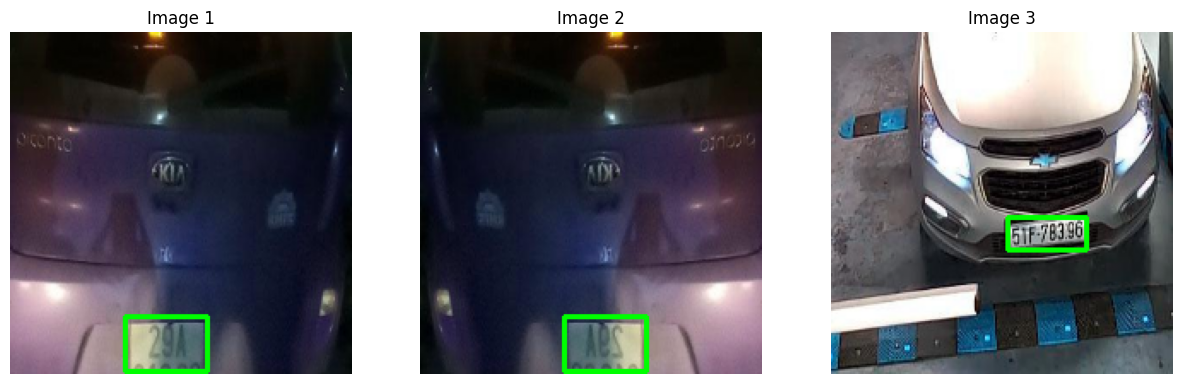

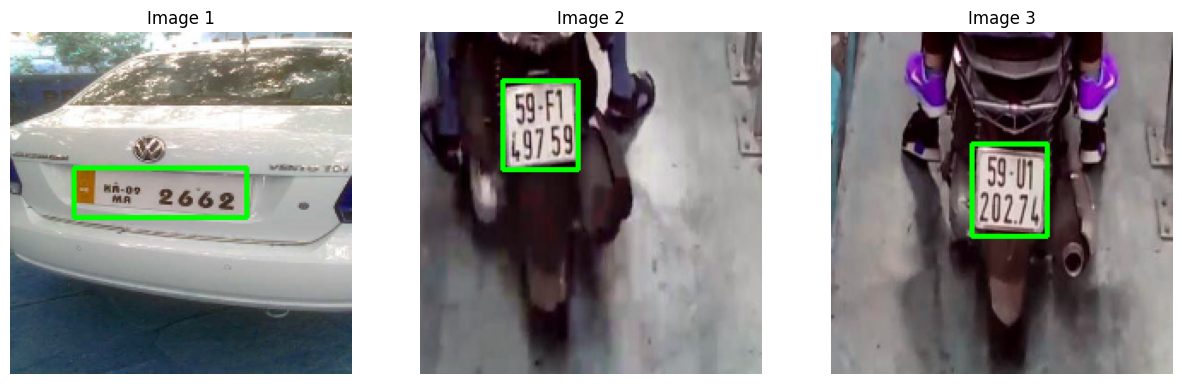

In [3]:
# Hàm vẽ bounding box lên ảnh
def draw_bboxes(images, bboxes):
    plt.figure(figsize=(15, 5))

    for i in range(3):  # Vẽ 3 hình ảnh đầu tiên
        img = images[i].copy()  # Copy ảnh gốc để tránh thay đổi ảnh gốc
        bbox = bboxes[i]

        # Chuyển bounding box về dạng pixel (không phải tỷ lệ)
        height, width, _ = img.shape
        xmin, ymin, xmax, ymax = bbox
        xmin, ymin, xmax, ymax = int(xmin * width), int(ymin * height), int(xmax * width), int(ymax * height)

        # Vẽ bounding box
        img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

        # Hiển thị ảnh
        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Image {i+1}")

    plt.show()

# Vẽ 3 hình ảnh đầu tiên với bounding boxes
draw_bboxes(X_train, y_train)
draw_bboxes(X_test, y_test)

## 2. Train model CNN

In [4]:


def build_custom_cnn(input_size):
    inputs = Input(shape=(input_size, input_size, 3))

    # Block 1
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    x = MaxPooling2D((2, 2))(x)

    # Block 2
    x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = MaxPooling2D((2, 2))(x)

    # Block 3
    x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = MaxPooling2D((2, 2))(x)

    # Flatten and Fully Connected Layers
    x = Flatten()(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation="relu")(x)

    # Output Layer: 4 neurons for (xmin, ymin, xmax, ymax)
    outputs = Dense(4, activation="sigmoid")(x)

    model = Model(inputs, outputs)
    return model

# Xây dựng mô hình

input_size = 200
model = build_custom_cnn(input_size)
model.compile(optimizer="adam", loss="mse", metrics=["mae", "accuracy"])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 200, 200, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    20,480,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,606,916 (78.61 MB)

 Trainable params: 20,606,916 (78.61 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:

# Huấn luyện mô hình
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32
)

Epoch 1/20


I0000 00:00:1733076671.976097      97 service.cc:145] XLA service 0x7c01e400d410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733076671.976187      97 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  7/346 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.3101 - loss: 0.0663 - mae: 0.2086   

I0000 00:00:1733076677.352366      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


346/346 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.6870 - loss: 0.0223 - mae: 0.1086 - val_accuracy: 0.8414 - val_loss: 0.0105 - val_mae: 0.0676
Epoch 2/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.8495 - loss: 0.0096 - mae: 0.0670 - val_accuracy: 0.8965 - val_loss: 0.0066 - val_mae: 0.0499
Epoch 3/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.8802 - loss: 0.0062 - mae: 0.0537 - val_accuracy: 0.9037 - val_loss: 0.0059 - val_mae: 0.0455
Epoch 4/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.8973 - loss: 0.0043 - mae: 0.0463 - val_accuracy: 0.9088 - val_loss: 0.0053 - val_mae: 0.0428
Epoch 5/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.9090 - loss: 0.0033 - mae: 0.0412 - val_accuracy: 0.8921 - val_loss: 0.0066 - val_mae: 0.0453
Epoch 6/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.9182 - loss: 0.0027 - mae: 0.0376 - val_accuracy: 0.9102 - val_loss: 0.0052 - val_mae: 0.0397
Epoch 7/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 9s 2

## 3. Đánh giá mô hình bằng biểu đồ hàm accuraccy , mae và hàm loss

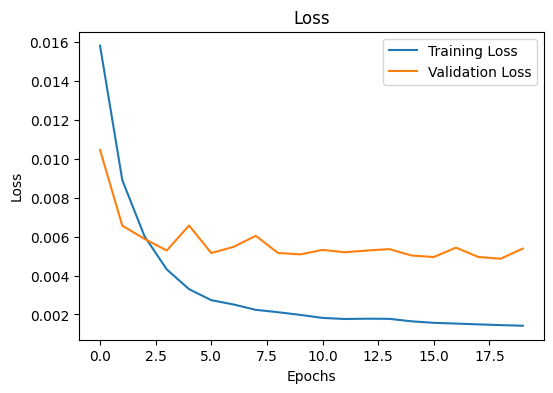

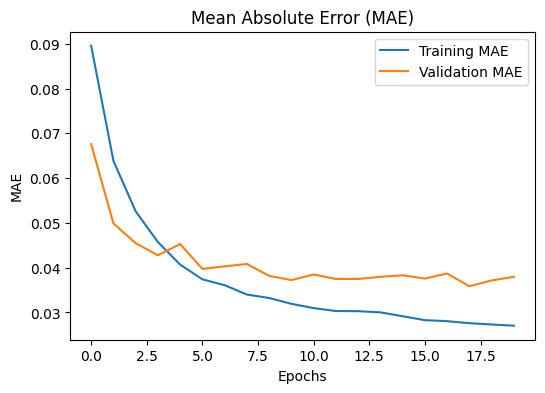

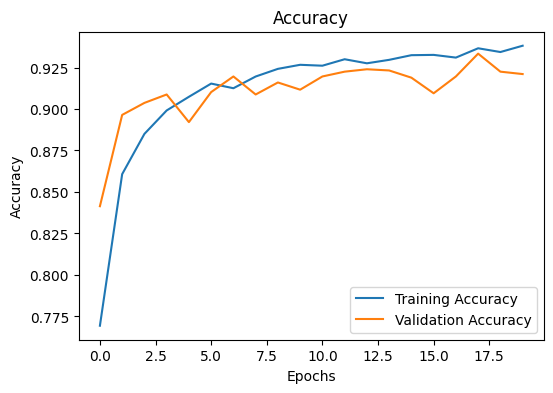

In [6]:
# Lấy dữ liệu lịch sử huấn luyện
history_dict = history.history

# Vẽ đồ thị Loss
plt.figure(figsize=(6, 4))
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Vẽ đồ thị MAE
plt.figure(figsize=(6, 4))
plt.plot(history_dict['mae'], label='Training MAE')
plt.plot(history_dict['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error (MAE)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

# Vẽ đồ thị Accuracy (nếu có)
if 'accuracy' in history_dict:
    plt.figure(figsize=(6, 4))
    plt.plot(history_dict['accuracy'], label='Training Accuracy')
    plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


## 4. Hàm trực quan hóa visualize prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


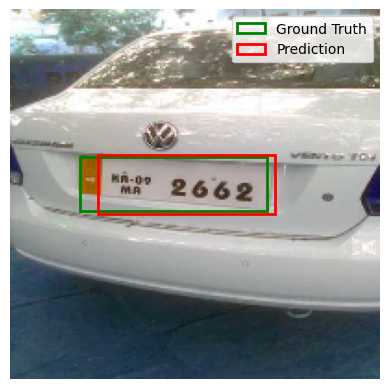

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


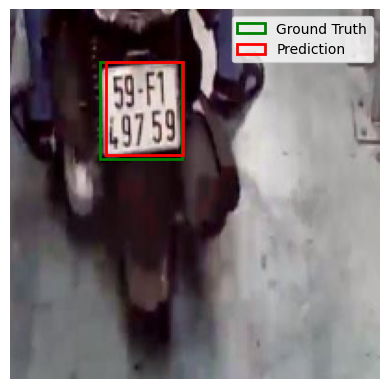

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


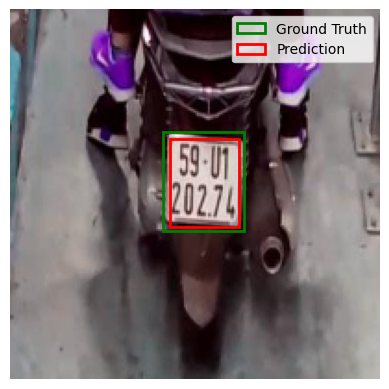

In [7]:
def visualize_prediction(image, bbox_true, bbox_pred):
    h, w, _ = image.shape
    plt.imshow(image)

    # Ground truth
    plt.gca().add_patch(plt.Rectangle(
        (bbox_true[0] * w, bbox_true[1] * h),  # xmin, ymin
        (bbox_true[2] - bbox_true[0]) * w,    # width
        (bbox_true[3] - bbox_true[1]) * h,    # height
        fill=False, edgecolor="green", linewidth=2, label="Ground Truth"
    ))

    # Prediction
    plt.gca().add_patch(plt.Rectangle(
        (bbox_pred[0] * w, bbox_pred[1] * h),  # xmin, ymin
        (bbox_pred[2] - bbox_pred[0]) * w,    # width
        (bbox_pred[3] - bbox_pred[1]) * h,    # height
        fill=False, edgecolor="red", linewidth=2, label="Prediction"
    ))
    plt.legend()
    plt.axis('off')
    plt.show()

# Vẽ 3 ảnh dự đoán
for i in range(3):
    sample_image = X_test[i]  # Chọn ảnh thứ i
    sample_bbox_true = y_test[i]  # Ground truth bounding box
    # Giả sử bạn đã có mô hình dự đoán
    sample_bbox_pred = model.predict(np.expand_dims(sample_image, axis=0))[0]  # Dự đoán từ mô hình

    visualize_prediction(sample_image, sample_bbox_true, sample_bbox_pred)


## 5. Lưu model

In [8]:
model.save('/kaggle/working/license_plate_model_2.h5')
print("Model saved successfully!")

Model saved successfully!


## 6. Test dự đoán

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Dự đoán bounding box: (291, 596, 467, 697)


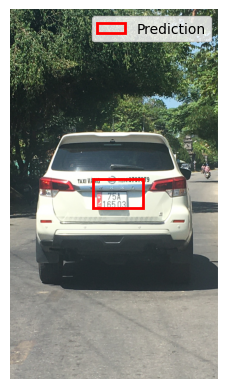

In [ ]:
def preprocess_image(image_path, input_size):
    """
    Đọc và chuẩn bị ảnh đầu vào cho mô hình.
    
    Args:
        image_path (str): Đường dẫn tới ảnh.
        input_size (int): Kích thước đầu vào của mô hình.
    
    Returns:
        numpy.ndarray: Ảnh đã được chuẩn hóa và resize.
        tuple: Kích thước gốc của ảnh (height, width).
    """
    image = cv2.imread(image_path)
    original_size = image.shape[:2]  # Lưu kích thước gốc (height, width)
    image_resized = cv2.resize(image, (input_size, input_size))
    image_normalized = image_resized / 255.0  # Chuẩn hóa về [0, 1]
    return image_normalized, original_size

def predict_bounding_box(image, model, original_size):
    """
    Dự đoán bounding box trên một ảnh duy nhất.
    
    Args:
        image (numpy.ndarray): Ảnh đã được chuẩn hóa và thay đổi kích thước.
        model (keras.Model): Mô hình CNN đã được huấn luyện.
        original_size (tuple): Kích thước gốc của ảnh (height, width).
    
    Returns:
        tuple: Bounding box dự đoán (xmin, ymin, xmax, ymax).
    """
    original_height, original_width = original_size
    
    # Dự đoán bounding box
    pred_bbox = model.predict(np.expand_dims(image, axis=0))[0]  # Output: [xmin, ymin, xmax, ymax]
    
    # Chuyển bounding box về kích thước gốc của ảnh
    xmin = int(pred_bbox[0] * original_width)
    ymin = int(pred_bbox[1] * original_height)
    xmax = int(pred_bbox[2] * original_width)
    ymax = int(pred_bbox[3] * original_height)
    
    return (xmin, ymin, xmax, ymax)

def visualize_prediction(image_path, bbox):
    """
    Hiển thị ảnh cùng với bounding box dự đoán.
    
    Args:
        image_path (str): Đường dẫn tới ảnh gốc.
        bbox (tuple): Bounding box (xmin, ymin, xmax, ymax).
    """
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.imshow(image_rgb)
    plt.gca().add_patch(plt.Rectangle(
        (bbox[0], bbox[1]),                # xmin, ymin
        bbox[2] - bbox[0],                 # width
        bbox[3] - bbox[1],                 # height
        fill=False, edgecolor="red", linewidth=2, label="Prediction"
    ))
    plt.legend()
    plt.axis("off")
    plt.show()

# Đường dẫn tới ảnh và mô hình
image_path = "/kaggle/input/test-model-aug/7115.jpg"


# Tiền xử lý ảnh
input_size = 200
image_preprocessed, original_size = preprocess_image(image_path, input_size)

# Dự đoán bounding box
pred_bbox = predict_bounding_box(image_preprocessed, model, original_size)

# In kết quả dự đoán
print(f"Dự đoán bounding box: {pred_bbox}")

# Hiển thị ảnh với bounding box
visualize_prediction(image_path, pred_bbox)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Dự đoán bounding box: (616, 390, 831, 455)


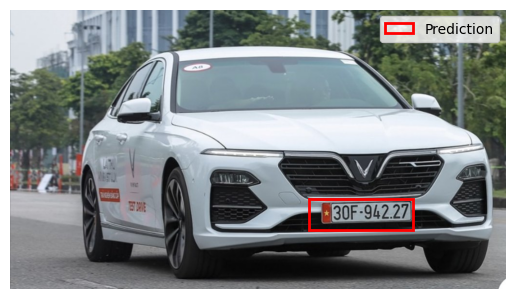

In [15]:
# Đường dẫn tới ảnh và mô hình
image_path = "/kaggle/input/test-model-aug/test2.jpeg"

image_preprocessed, original_size = preprocess_image(image_path, input_size)

# Dự đoán bounding box
pred_bbox = predict_bounding_box(image_preprocessed, model, original_size)
# In kết quả dự đoán
print(f"Dự đoán bounding box: {pred_bbox}")

# Hiển thị ảnh với bounding box
visualize_prediction(image_path, pred_bbox)
